In [1]:
# Question 3a: GP (10%)

# Packages
import numpy as np
import random as rand
from copy import deepcopy
from inspect import signature


# Let numpy throw errors
np.seterr(all='raise')

# Constants
b = 1        # Range of datapoints
D = 40       # Number of datapoints
trials = 50  # Number of times PSO is run
XOR = 0.9    # Crossover rate
MUR = 0.1    # Mutation rate
PMR = 0.02   # Point mutation rate
GEN = 40     # Maximum allowed number of generations
MINDEPTH = 2 # Minimum initial tree depth
MAXDEPTH = 5 # Maximum initial tree depth

# Functions
def epsilon_close(x, y):
    return abs(x - y) < 0.01

def target(x):
    return x**4 + x**3 + x**2 + x

# Data
X = np.array([rand.uniform(-b, b) for _ in range(D)])
Y = np.array([target(x) for x in X])

# Node values
def add(x, y): return x + y
def mul(x, y): return x * y
F = [add, mul]
T = ['x']

# Genetic program class
class GP: 
    
    # Constructor: 
    def __init__(self, v = None, l = None, r = None): 
        self.v = v        # node value
        self.l = l        # left arg
        self.r = r        # right arg
        
    # String repr. of tree root node
    def to_str(self): 
        if (self.v in F): return self.v.__name__
        else: return str(self.v)
    
    # Print whole tree
    def tree_print(self, prefix=""): # Print program tree
        print("%s%s" % (prefix, self.to_str()))        
        if self.l: self.l.tree_print(prefix + "  ")
        if self.r: self.r.tree_print(prefix + "  ")

    # Run the program on input
    def apply(self, x):
        if self.v in F:  
            try:
                return self.v(self.l.apply(x), self.r.apply(x))
            except FloatingPointError:
                return float("inf")
        elif self.v == 'x': return x
        else: return self.v
    
    # Generate random tree
    def random_tree(self, grow, max_depth, depth = 0):
        if depth < MINDEPTH or (depth < max_depth and not grow): 
            self.v = rand.choice(F)
        elif depth >= max_depth:   
            self.v = 'x'
        else: # intermediate depth, grow
            if rand.uniform(0, 1) > 0.5:
                self.v = rand.choice(T)
            else: self.v = rand.choice(F)
        if self.v in F:
            self.l = GP()
            self.l.random_tree(grow, max_depth, depth = depth + 1)            
            self.r = GP()
            self.r.random_tree(grow, max_depth, depth = depth + 1)
    
    # Mutate
    def mutate(self): 
        if rand.uniform(0, 1) < MUR:
            self.random_tree(grow = True, max_depth = 2)
        elif self.l: self.l.mutate()
        elif self.r: self.r.mutate() 
            
    # Point mutate
    def point_mutate(self):
        if rand.uniform(0, 1) < PMR:
            if self.v in T: self.v = rand.choice(T)
            else: self.v = rand.choice(F)
        if self.l: self.l.point_mutate()
        if self.r: self.r.point_mutate()
            
     # Tree depth
    def depth(self, curr_depth=0):
        below = curr_depth
        if self.l: below = max(below, self.l.depth(curr_depth + 1))
        if self.r: below = max(below, self.r.depth(curr_depth + 1))
        return below
    
    # Tree size in nodes
    def size(self): 
        if self.v in T: return 1
        l = self.l.size() if self.l else 0
        r = self.r.size() if self.r else 0
        return 1 + l + r

    # Builds an identical tree
    def build_subtree(self): 
        t = GP()
        t.v = self.v
        if self.l: t.l = self.l.build_subtree()
        if self.r: t.r = self.r.build_subtree()
        return t
    
    # Scan tree
    def scan_tree(self, count, second): 
        count[0] -= 1 # note: count is list, so it's passed "by reference"
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.v = second.v
                self.l = second.l
                self.r = second.r
        else:  
            ret = None              
            if self.l and count[0] > 1: ret = self.l.scan_tree(count, second)  
            if self.r and count[0] > 1: ret = self.r.scan_tree(count, second)  
            return 
        
    # Crossover two trees at random
    def crossover(self, other):
        if rand.random() < XOR:
            second = other.scan_tree([rand.randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([rand.randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree

# Fitness
def fitness(gp):
    return 1 / (1 + np.sum([abs(gp.apply(X[i]) - Y[i]) for i in range(D)])) 
    
# Selection
def max_select(gps): 
    fitnesses = np.array([fitness(gp) for gp in gps])
    return deepcopy(gps[np.argmax(fitnesses)])

# Roulette-wheel selection
def roulette_select(gps, fitnesses):
    sum_fitness = np.sum(fitnesses)
    if sum_fitness == 0.0:
        return deepcopy(rand.choice(gps))
    else:
        norm_fitnesses = fitnesses / sum_fitness
        choice = rand.choices(gps, weights=norm_fitnesses, k=1)[0]
        return deepcopy(choice)
    
# Generation initial population
def init_population(POP): 
    pop = []
    for md in range(3, MAXDEPTH+1):
        for i in range(int(POP/6)):
            t = GP()
            t.random_tree(grow = True, max_depth = md) # Grow method
            pop.append(t)
        for i in range(int(POP/6)):
            t = GP()
            t.random_tree(grow = False, max_depth = md) # Full method
            pop.append(t)
    return pop



# Records
res = 15 # Resolution
POPs = list(range(60, 601, (600 - 60) // res))
F_g = np.zeros((len(POPs), trials))       # Fitnesses per population size and trial
G_c = np.zeros((len(POPs), trials))       # Generation until convergence per population size and trial

for k, POP in enumerate(POPs):
    for trial in range(trials):
        # 1. Generate an initial population of GPs
        GPs   = init_population(POP) # Programs
        F_p   = np.zeros(POP)     # Fitnesses
        f_g   = 0.0               # Trial-best fitness
        gp_g  = None              # Trial-best program 
        converged = False         # Did this run converge?
        
        # 2. Run 
        for gen in range(GEN):
            # Evaluate fitnesses, replace GB
            for i in range(POP):
                f_i = fitness(GPs[i])
                F_p[i] = f_i
                if f_i > f_g:   # Global best
                    gp_g = deepcopy(GPs[i])
                    f_g = f_i

            # Check for termination criterion
            if epsilon_close(f_g, 1.0): 
                converged = True
                G_c[k][trial] += gen
                break

            # Create new population
            GP_new = []
            for i in range(POP):
                gp_new = deepcopy(GPs[i])
                mate   = roulette_select(GPs, F_p)
                gp_new.crossover(mate)    # Crossover
                gp_new.mutate()           # Mutation
                gp_new.point_mutate()     # Point-mutation
                GP_new.append(gp_new)     # Add to new population

            GPs = GP_new # Replace old population
        
        # Not solved, took time.
        if not converged:
            G_c[k][trial] += GEN
        
        # Record trial-best fitness
        F_g[k][trial] = f_g
        

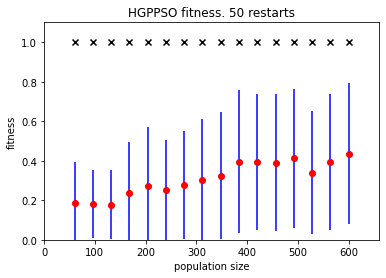

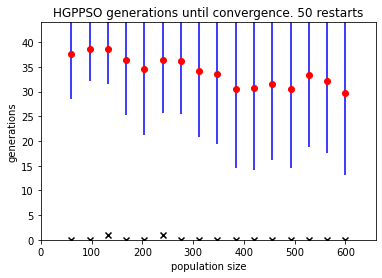

In [3]:
import matplotlib.pyplot as plt
F_g_best = np.max(F_g, axis=1)
F_g_avg  = np.mean(F_g,axis=1)
F_g_std  = np.std(F_g, axis=1)

# Plot. X = population. Y = fitness
fig, ax = plt.subplots()
title = "PSO fitness. " + str(trials) + " restarts"
ax.set_title(title)
ax.set_xlabel("population size")
ax.set_ylabel("fitness")
ax.set_xlim(0, 600 * 1.1)
ax.set_ylim(0, 1 * 1.1)
plt.scatter(POPs, F_g_best, c='#000000',marker='x')
plt.errorbar(POPs, F_g_avg, F_g_std, ecolor='blue', c='#FF0000', linestyle='None', marker='o')
plt.show()

G_c_best = np.min(G_c, axis=1)
G_c_avg  = np.mean(G_c,axis=1)
G_c_std  = np.std(G_c, axis=1)

# Plot. X = population. Y = generations
fig, ax = plt.subplots()
title = "PSO generations until convergence. " + str(trials) + " restarts"
ax.set_title(title)
ax.set_xlabel("population size")
ax.set_ylabel("generations")
ax.set_xlim(0, 600 * 1.1)
ax.set_ylim(0, 40 * 1.1)
plt.scatter(POPs, G_c_best, c='#000000',marker='x')
plt.errorbar(POPs, G_c_avg, G_c_std, ecolor='blue', c='#FF0000', linestyle='None', marker='o')
plt.show()